# secsy demo

I'm going to show a few examples of how to use secsy (also for testing/validation purposes)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import secsy
from secsy import utils
from secsy import get_SECS_J_G_matrices, get_SECS_B_G_matrices


## Plots of basis function polar angle dependence
First, use the two matrix functions imported above to plot the radial (or polar angle) dependence of the SECS currents functions. I'll do this by placing one SECS at the north pole, and data points at different colatitudes away from the pole.

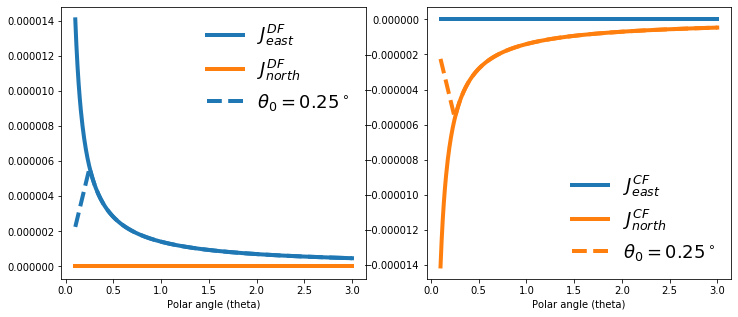

In [2]:
lat_secs = 90
lon_secs = 0
theta = np.linspace(1e-1, 3, 500) # starting at very small number to avoid divison by 0
lat = 90 - theta
lon = theta * 0

fig = plt.figure(figsize = (12, 5))
axdf = fig.add_subplot(121)
axcf = fig.add_subplot(122)

linestyles = ['-', '--']

RI = secsy.utils.RE + 110*1e3
for i, theta0 in enumerate([0, .25]):
    Ge_df, Gn_df = get_SECS_J_G_matrices(lat, lon, lat_secs, lon_secs, current_type = 'divergence_free', singularity_limit = theta0 * np.pi / 180 * RI)
    Ge_cf, Gn_cf = get_SECS_J_G_matrices(lat, lon, lat_secs, lon_secs, current_type = 'curl_free'      , singularity_limit = theta0 * np.pi / 180 * RI)

    je_df = Ge_df.dot(np.array([1]))
    jn_df = Gn_df.dot(np.array([1]))
    je_cf = Ge_cf.dot(np.array([1]))
    jn_cf = Gn_cf.dot(np.array([1]))


    axdf.plot(theta, je_df, label = '$J_{east}^{DF}$'  if i == 0 else (r'$\theta_0 = %.2f^\circ$' % theta0), linewidth = 4, color = 'C0', linestyle = linestyles[i])
    axdf.plot(theta, jn_df, label = '$J_{north}^{DF}$' if i == 0 else None, linewidth = 4, color = 'C1', linestyle = linestyles[i])
    axcf.plot(theta, je_cf, label = '$J_{east}^{CF}$'  if i == 0 else None, linewidth = 4, color = 'C0', linestyle = linestyles[i])
    axcf.plot(theta, jn_cf, label = '$J_{north}^{CF}$' if i == 0 else (r'$\theta_0 = %.2f^\circ$' % theta0), linewidth = 4, color = 'C1', linestyle = linestyles[i])
    axdf.legend(frameon = False, fontsize = 18)
    axcf.legend(frameon = False, fontsize = 18)
    axcf.set_xlabel('Polar angle (theta)')
    axdf.set_xlabel('Polar angle (theta)')
    

Do the same with the magnetic field of these currents - evaluated 100 km abvoe and below the default current height of 110 km:

Text(0, 0.5, 'Magnetic field magnitude\nUnit SECS')

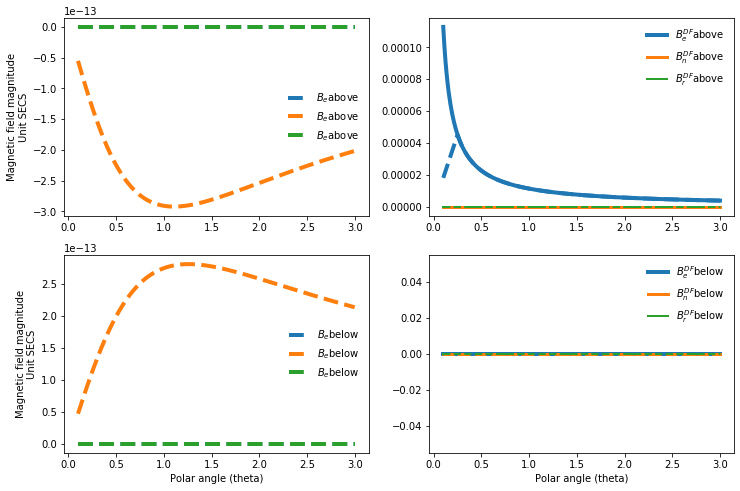

In [3]:
r = {'above':secsy.utils.RE + 210*1e3, 'below':secsy.utils.RE }

fig = plt.figure(figsize = (12, 8))
axdf = {'above':fig.add_subplot(221), 'below':fig.add_subplot(223)}
axcf = {'above':fig.add_subplot(222), 'below':fig.add_subplot(224)}

for key in r.keys():
    
    for i, theta0 in enumerate([0, .25]):
        Ge_cf, Gn_cf, Gr_cf = get_SECS_B_G_matrices(lat, lon, r[key], lat_secs, lon_secs, current_type = 'curl_free', singularity_limit = theta0 * np.pi / 180 * RI)

        Be_cf = Ge_cf.dot(np.array([1]))
        Bn_cf = Gn_cf.dot(np.array([1]))
        Br_cf = Gr_cf.dot(np.array([1]))
        
        axcf[key].plot(theta, Be_cf, label = '$B_{e}^{DF}$' + key if i == 0 else None, linewidth = 4, color = 'C0', linestyle = linestyles[i])
        axcf[key].plot(theta, Bn_cf, label = '$B_{n}^{DF}$' + key if i == 0 else None, linewidth = 3, color = 'C1', linestyle = linestyles[i])
        axcf[key].plot(theta, Br_cf, label = '$B_{r}^{DF}$' + key if i == 0 else None, linewidth = 2, color = 'C2', linestyle = linestyles[i])
    
    axcf[key].legend(frameon = False)

        
    Ge_df, Gn_df, Gr_df = get_SECS_B_G_matrices(lat, lon, r[key], lat_secs, lon_secs, current_type = 'divergence_free')

    Be_df = Ge_df.dot(np.array([1]))
    Bn_df = Gn_df.dot(np.array([1]))
    Br_df = Gr_cf.dot(np.array([1]))
    axdf[key].plot(theta, Be_df, label = '$B_{e}$' + key, linewidth = 4, color = 'C0', linestyle = linestyles[i])
    axdf[key].plot(theta, Bn_df, label = '$B_{e}$' + key, linewidth = 4, color = 'C1', linestyle = linestyles[i])
    axdf[key].plot(theta, Br_df, label = '$B_{e}$' + key, linewidth = 4, color = 'C2', linestyle = linestyles[i])
    axdf[key].legend(frameon = False)
    
axdf['below'].set_xlabel('Polar angle (theta)')
axcf['below'].set_xlabel('Polar angle (theta)')
axdf['above'].set_ylabel('Magnetic field magnitude\nUnit SECS')
axdf['below'].set_ylabel('Magnetic field magnitude\nUnit SECS')

        


## Plot vector field of two SECS poles

Next I will plot the vector field of two SECS poles to show how to use the matrices to calculate the combined contribution of multiple SECS poles on a set of points. I'll use Cartopy, but I'll have to make a helper function first to get the projection right:

In [4]:

def Geocentric_to_PlateCarree_vector_components(east, north, latitude):
    """ convert east north vector components to Plate Carree projection 

        parameters
        ----------
        east: array-like
            eastward components
        north: array-like
            westward components
        latitude: array-like
            latitude of each vector

        returns
        -------
        east, north in Plate Carree projection
        Preserveres shape and norm

    """
    magnitude = np.sqrt(east**2 + north**2)

    east_pc = east / np.cos(latitude * np.pi / 180)

    magnitude_pc = np.sqrt(east_pc**2 + north**2)

    east_pc  = east_pc * magnitude / magnitude_pc
    north_pc = north * magnitude / magnitude_pc

    return east_pc, north_pc


Ready to calcualte and plot the vector field. I'll start by defining two points which are locations of SECS poles, and assign two different amplitudes to them:

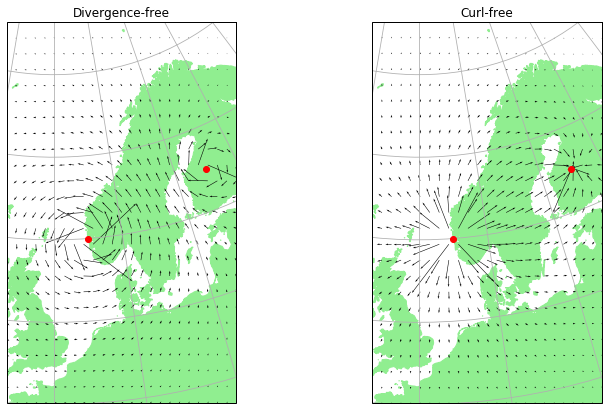

In [5]:
lat_secs = np.array([60, 63])
lon_secs = np.array([5, 25])
m = np.array([2, -1]) # amplitudes
RES = 25 # grid resolution in km

# set up figure and projection:
extent = [-5, 20, 48, 75]
central_longitude = 0
central_latitude = (extent[-1] - extent[-2]) / 2 + extent[-2]
proj = ccrs.LambertAzimuthalEqualArea(central_latitude = central_latitude, central_longitude = central_longitude)

fig = plt.figure(figsize = (12, 7))
ax_cf = fig.add_subplot(122, projection = proj)
ax_df = fig.add_subplot(121, projection = proj)

land = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                    edgecolor='face',
                                    facecolor='lightgreen')

for ax in [ax_df, ax_cf]:
    ax.add_feature(land, zorder=0)
    ax.gridlines()
    ax.set_extent(extent)
    ax.scatter(lon_secs, lat_secs, transform = ccrs.Geodetic(), c = 'red', marker = 'o', zorder = 5)

# use the map projection to create a grid, and calcualte the lat/lon of the grid points:
x, y = np.meshgrid( np.linspace(*(ax.get_xlim() + (RES,))), 
                    np.linspace(*(ax.get_ylim() + (RES,))))

lon, lat, _ = ccrs.Geodetic().transform_points(ax.projection, x.flatten(), y.flatten()).T

# plot divergence-free vector field:
Ge, Gn = get_SECS_J_G_matrices(lat, lon, lat_secs, lon_secs, current_type = 'divergence_free', singularity_limit = RES/10)
Je, Jn = Ge.dot(m), Gn.dot(m)
Je_pc, Jn_pc = Geocentric_to_PlateCarree_vector_components(Je, Jn, lat.flatten())
ax_df.quiver(lon.flatten(), lat.flatten(), Je_pc, Jn_pc, transform = ccrs.PlateCarree())
ax_df.set_title('Divergence-free')

# plot curl-free vector field:
Ge, Gn = get_SECS_J_G_matrices(lat, lon, lat_secs, lon_secs, current_type = 'curl_free', singularity_limit = RES/10)
Je, Jn = Ge.dot(m), Gn.dot(m)
Je_pc, Jn_pc = Geocentric_to_PlateCarree_vector_components(Je, Jn, lat.flatten())
ax_cf.quiver(lon.flatten(), lat.flatten(), Je_pc, Jn_pc, transform = ccrs.PlateCarree())
ax_cf.set_title('Curl-free')

plt.show()